# Preprocessing

In [117]:
module Batch
    using Base.Dates
    const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
    data_dir = "../"
    stan_increment = Day(3)
    stan_days = Day(9)
    janfirst = Date(2015,1,1)
    include(data_dir*"/src/TempModel.jl")
    include(data_dir*"/src/batch_diagnostics.jl")
end
TempModel = Batch.TempModel

Batch.TempModel

In [106]:
using Base.Dates
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
data_dir = "../"
;

In [56]:
# obtain the list of stations
logging(DevNull; kind=:warn)
isdList=TempModel.read_isdList(; data_dir=data_dir)
logging()
# just the Iowa stations
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF]],:]
isdSubset

# obtain the hourly temperature measurements for those stations
hourly_cat=TempModel.read_Stations(isdSubset; data_dir=data_dir)
# mark station 3 (Waterloo) as the test station
itest=3
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
# get the USAF code for the test station
test_usaf=isdSubset[itest,:USAF]

# emulate daily Tx/Tn measurement
# hr_measure = Hour(17) # number between 0 and 23
# hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
# TnTx = DataTables.by(hourly_test, :ts_day, df -> DataTable(
#     Tn=minimum(df[:temp].values), 
#     Tx=maximum(df[:temp].values)))
# # add column to test data for TnTx (useful for plotting)
# test_trimmed=join(hourly_test, TnTx, on=:ts_day)
# head(test_trimmed)

725480

In [62]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

INFO: Recompiling stale cache file /Users/imolk/Library/Julia/packages_experimental/lib/v0.6/PyPlot.ji for module PyPlot.


In [ ]:
all_impt_diagn = Dict{String, Vector{ImputationDiagnostic}}()

In [ ]:
import DataFrames

In [362]:
convert(Millisecond, Hour(1))

3600000 milliseconds

In [378]:
time_diffs = diff(hourly_test[:ts])/convert(Millisecond, Minute(1))
minimum(time_diffs), maximum(time_diffs)

(1.0, 120.0)

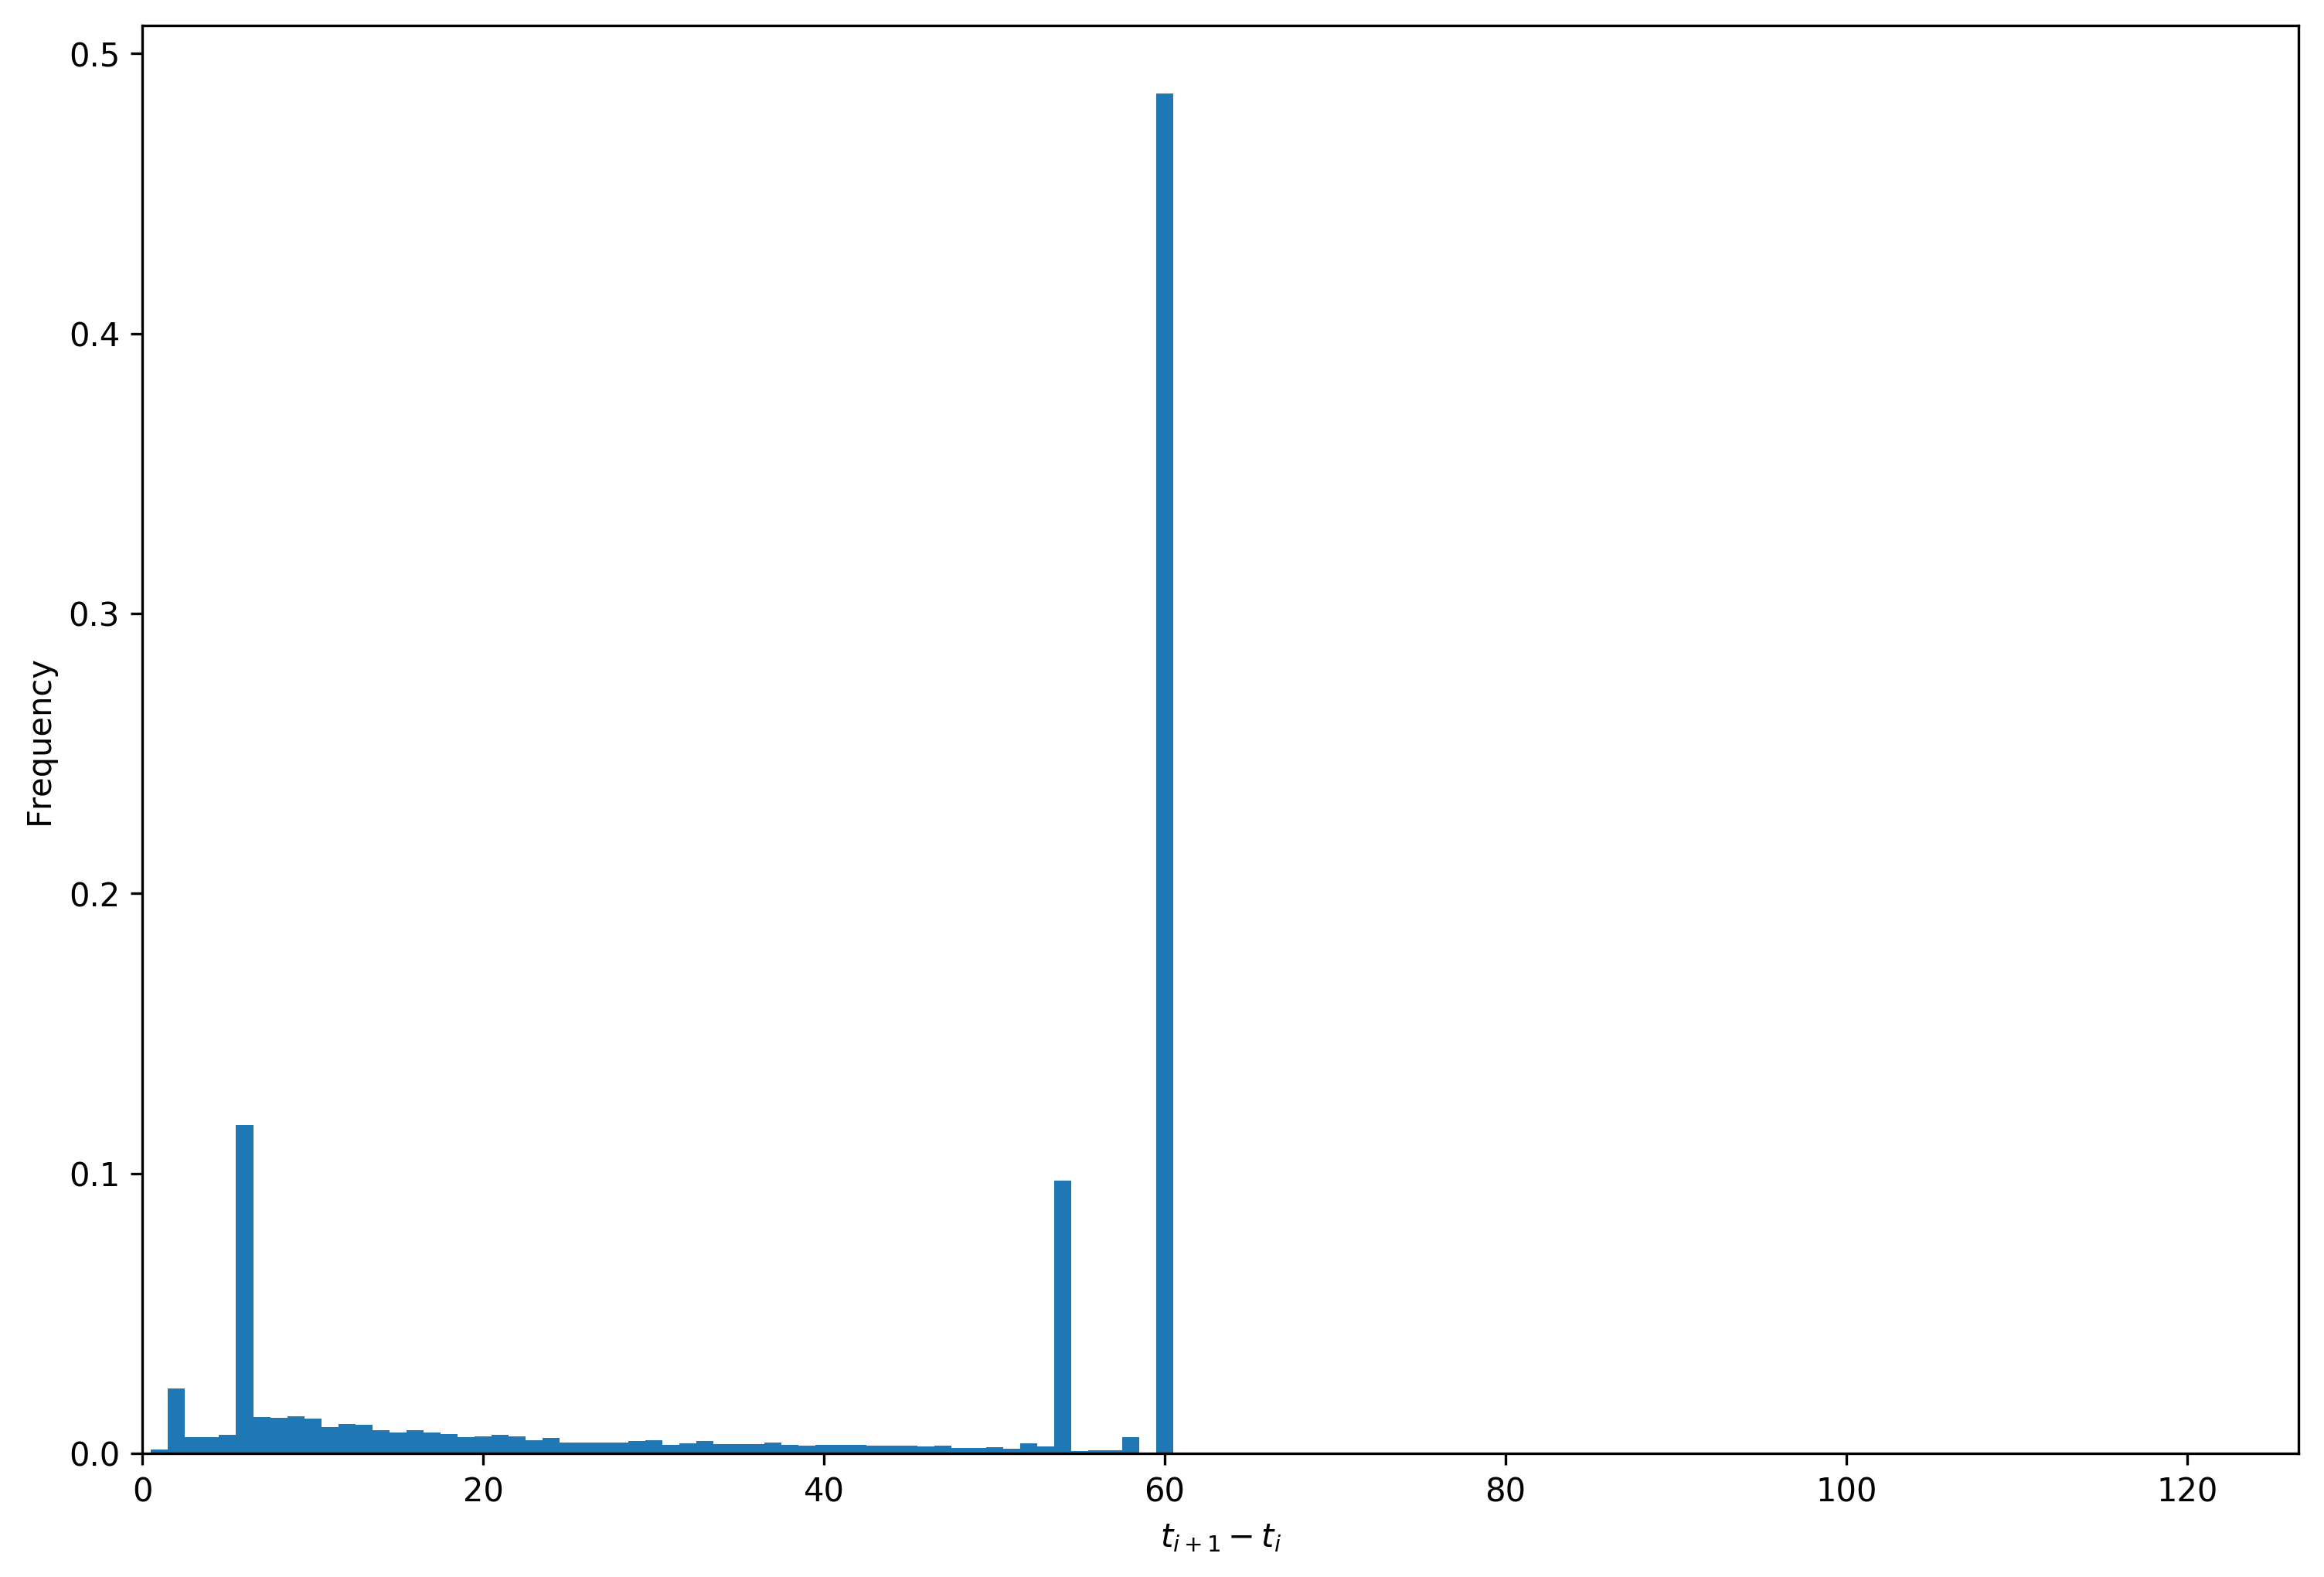

In [382]:
plt.plt[:hist](time_diffs, bins=-0.5:1:121, normed=true)
plt.xlim(0.0)
plt.xlabel(L"$t_{i+1}-t_i$")
plt.ylabel("Frequency")
plt.savefig("../figures/histogram_time_diff.png", bbox_inches="tight")
plt.savefig("../figures/histogram_time_diff.pdf", bbox_inches="tight")

# Mean Temperature: truth

In [229]:
# function mean_temp{V1<:AbstractVector, V2<:AbstractVector}(temp::V1, ts::V2)
#     weights = zeros(Float64, length(temp))
#     diff_ts = diff(ts) ./ Base.Dates.Millisecond(1)
#     weights[1:end-1] .+= diff_ts/2.0
#     weights[2:end] .+= diff_ts/2.0
#     wvec = StatsBase.Weights(weights)
#     return mean(temp, wvec)
# end
function mean_temp{V1<:AbstractVector, V2<:AbstractVector}(temp::V1, ts::V2)
    temp_midpoints = StatsBase.midpoints(temp)
    diff_ts = diff(ts) ./ Base.Dates.Millisecond(1)
    weights = StatsBase.Weights(diff_ts)
    return mean(temp_midpoints, weights)
end

true_mean_temp = mean_temp(hourly_test[:temp], hourly_test[:ts])

9.49667347800774

## obtained by averaging Tn and Tx

In [76]:
hours = Hour(0):Hour(1):Hour(23)

0 hours:1 hour:23 hours

In [78]:
meanTnTx_by_hr = Vector{Float64}(length(hours))
for (i_hr, hr) in enumerate(hours)
    TnTx_test = TempModel.test_data(hourly_test, itest, hr)
    meanTnTx = mean((mean(TnTx_test[:Tn]), mean(TnTx_test[:Tx])))
    meanTnTx_by_hr[i_hr] = meanTnTx
end

In [387]:
m=extrema(meanTnTx_by_hr)
m[2]-m[1]

1.1867486338797821

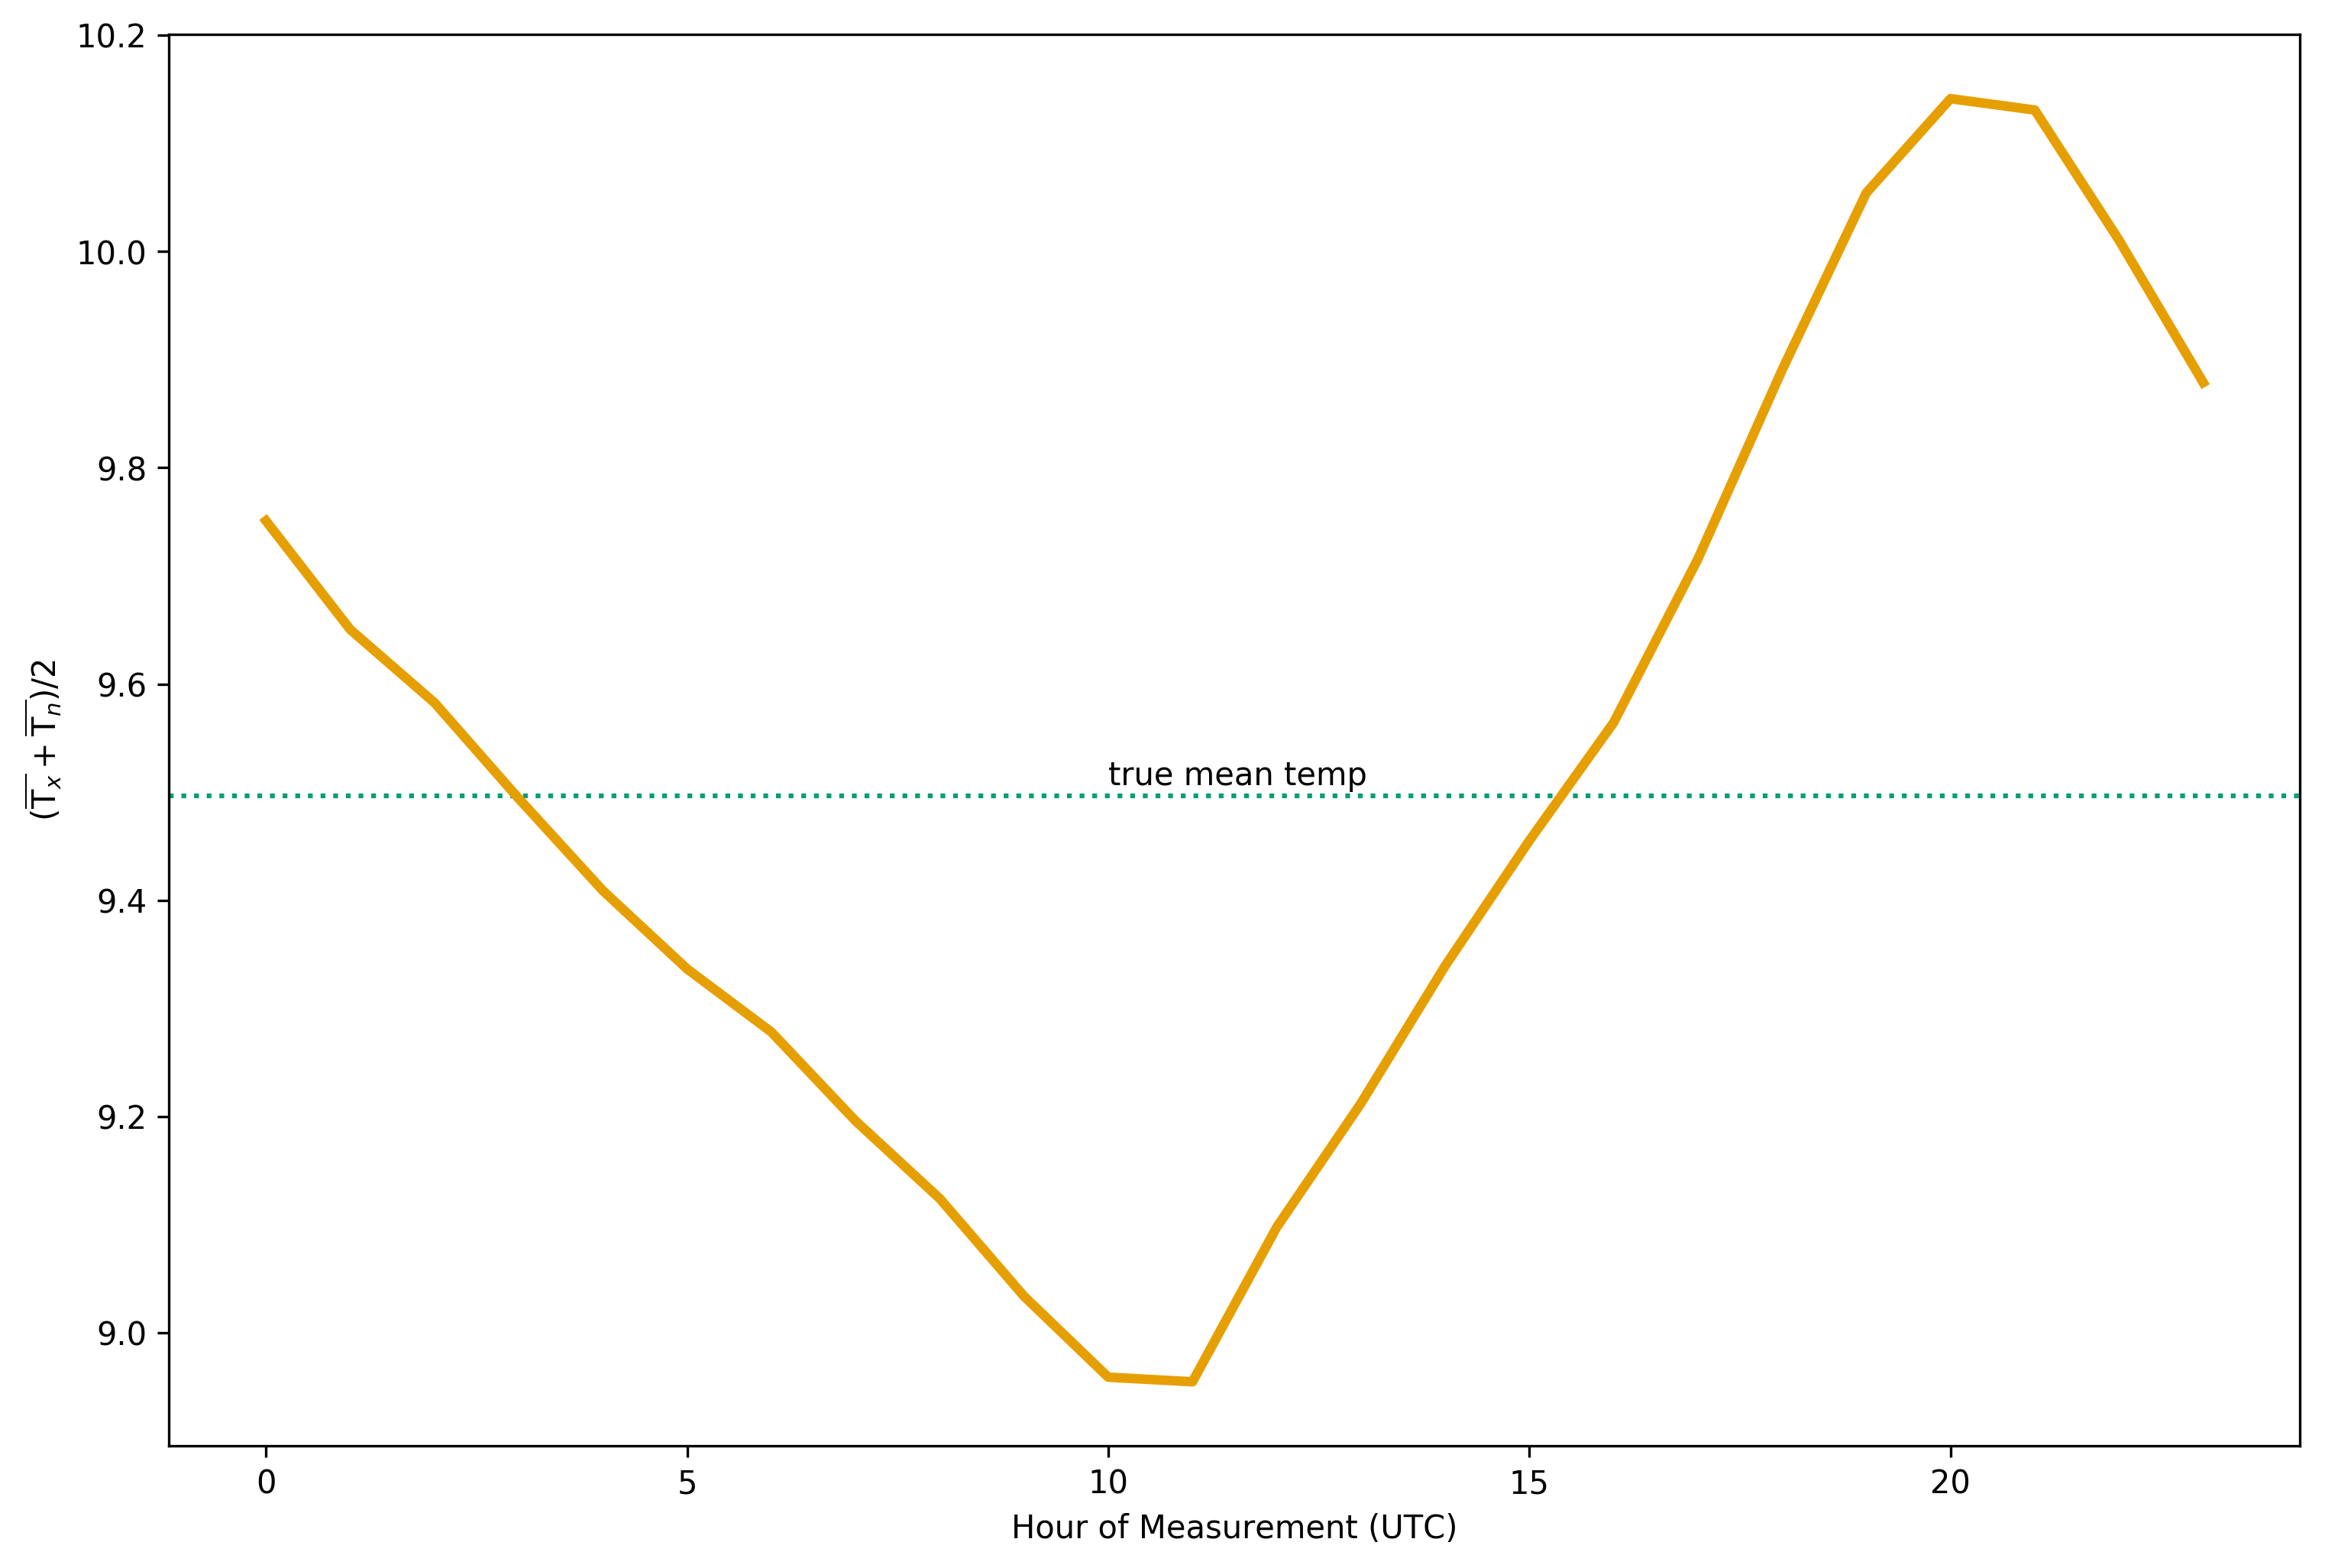

In [383]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
plt.plot(hours ./ Hour(1), meanTnTx_by_hr, linewidth=3, color=cbbPalette[1])
plt.axhline(true_mean_temp, color=cbbPalette[3], linestyle=":", zorder=-1)
plt.text(10.0, true_mean_temp+0.01, "true mean temp")
plt.xlabel("Hour of Measurement (UTC)")
plt.ylabel(L"$(\overline{\mathrm{T}_x} + \overline{\mathrm{T}_n}) / 2$")
plt.savefig("../figures/waterloo_mean_temp_by_hour.png", bbox_inches="tight")
plt.savefig("../figures/waterloo_mean_temp_by_hour.pdf", bbox_inches="tight")
;

# Read Imputations

In [214]:
module Batch
    using Base.Dates
    const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
    data_dir = "../"
    stan_increment = Day(3)
    stan_days = Day(9)
    janfirst = Date(2015,1,1)
    include(data_dir*"/src/TempModel.jl")
    include(data_dir*"/src/batch_diagnostics.jl")
end
TempModel = Batch.TempModel

Batch.TempModel

In [218]:
typeof(ts[1])

DateTime

In [240]:
"""
    Time to the edge of the time window.
    
    For each time ts_i, returns either
        ts_i - minimum(ts)
    or
        maximum(ts) - ts_i
    whichever one is smallest.
"""
function get_buffer(ts::AbstractVector{DateTime})
    return min.(ts.-minimum(ts), maximum(ts).-ts)
end

import Base.middle
function Base.middle(d1::DateTime, d2::DateTime)
    diff = d2-d1
    halfdiff = diff/2
    mid = d1 + halfdiff
    return mid
end
function get_midpoints_buffer(ts::AbstractVector{DateTime})
    mid = StatsBase.midpoints(ts)
    return min.(mid.-minimum(ts), maximum(ts).-mid)
end

get_midpoints_buffer (generic function with 1 method)

In [243]:
using DataFrames

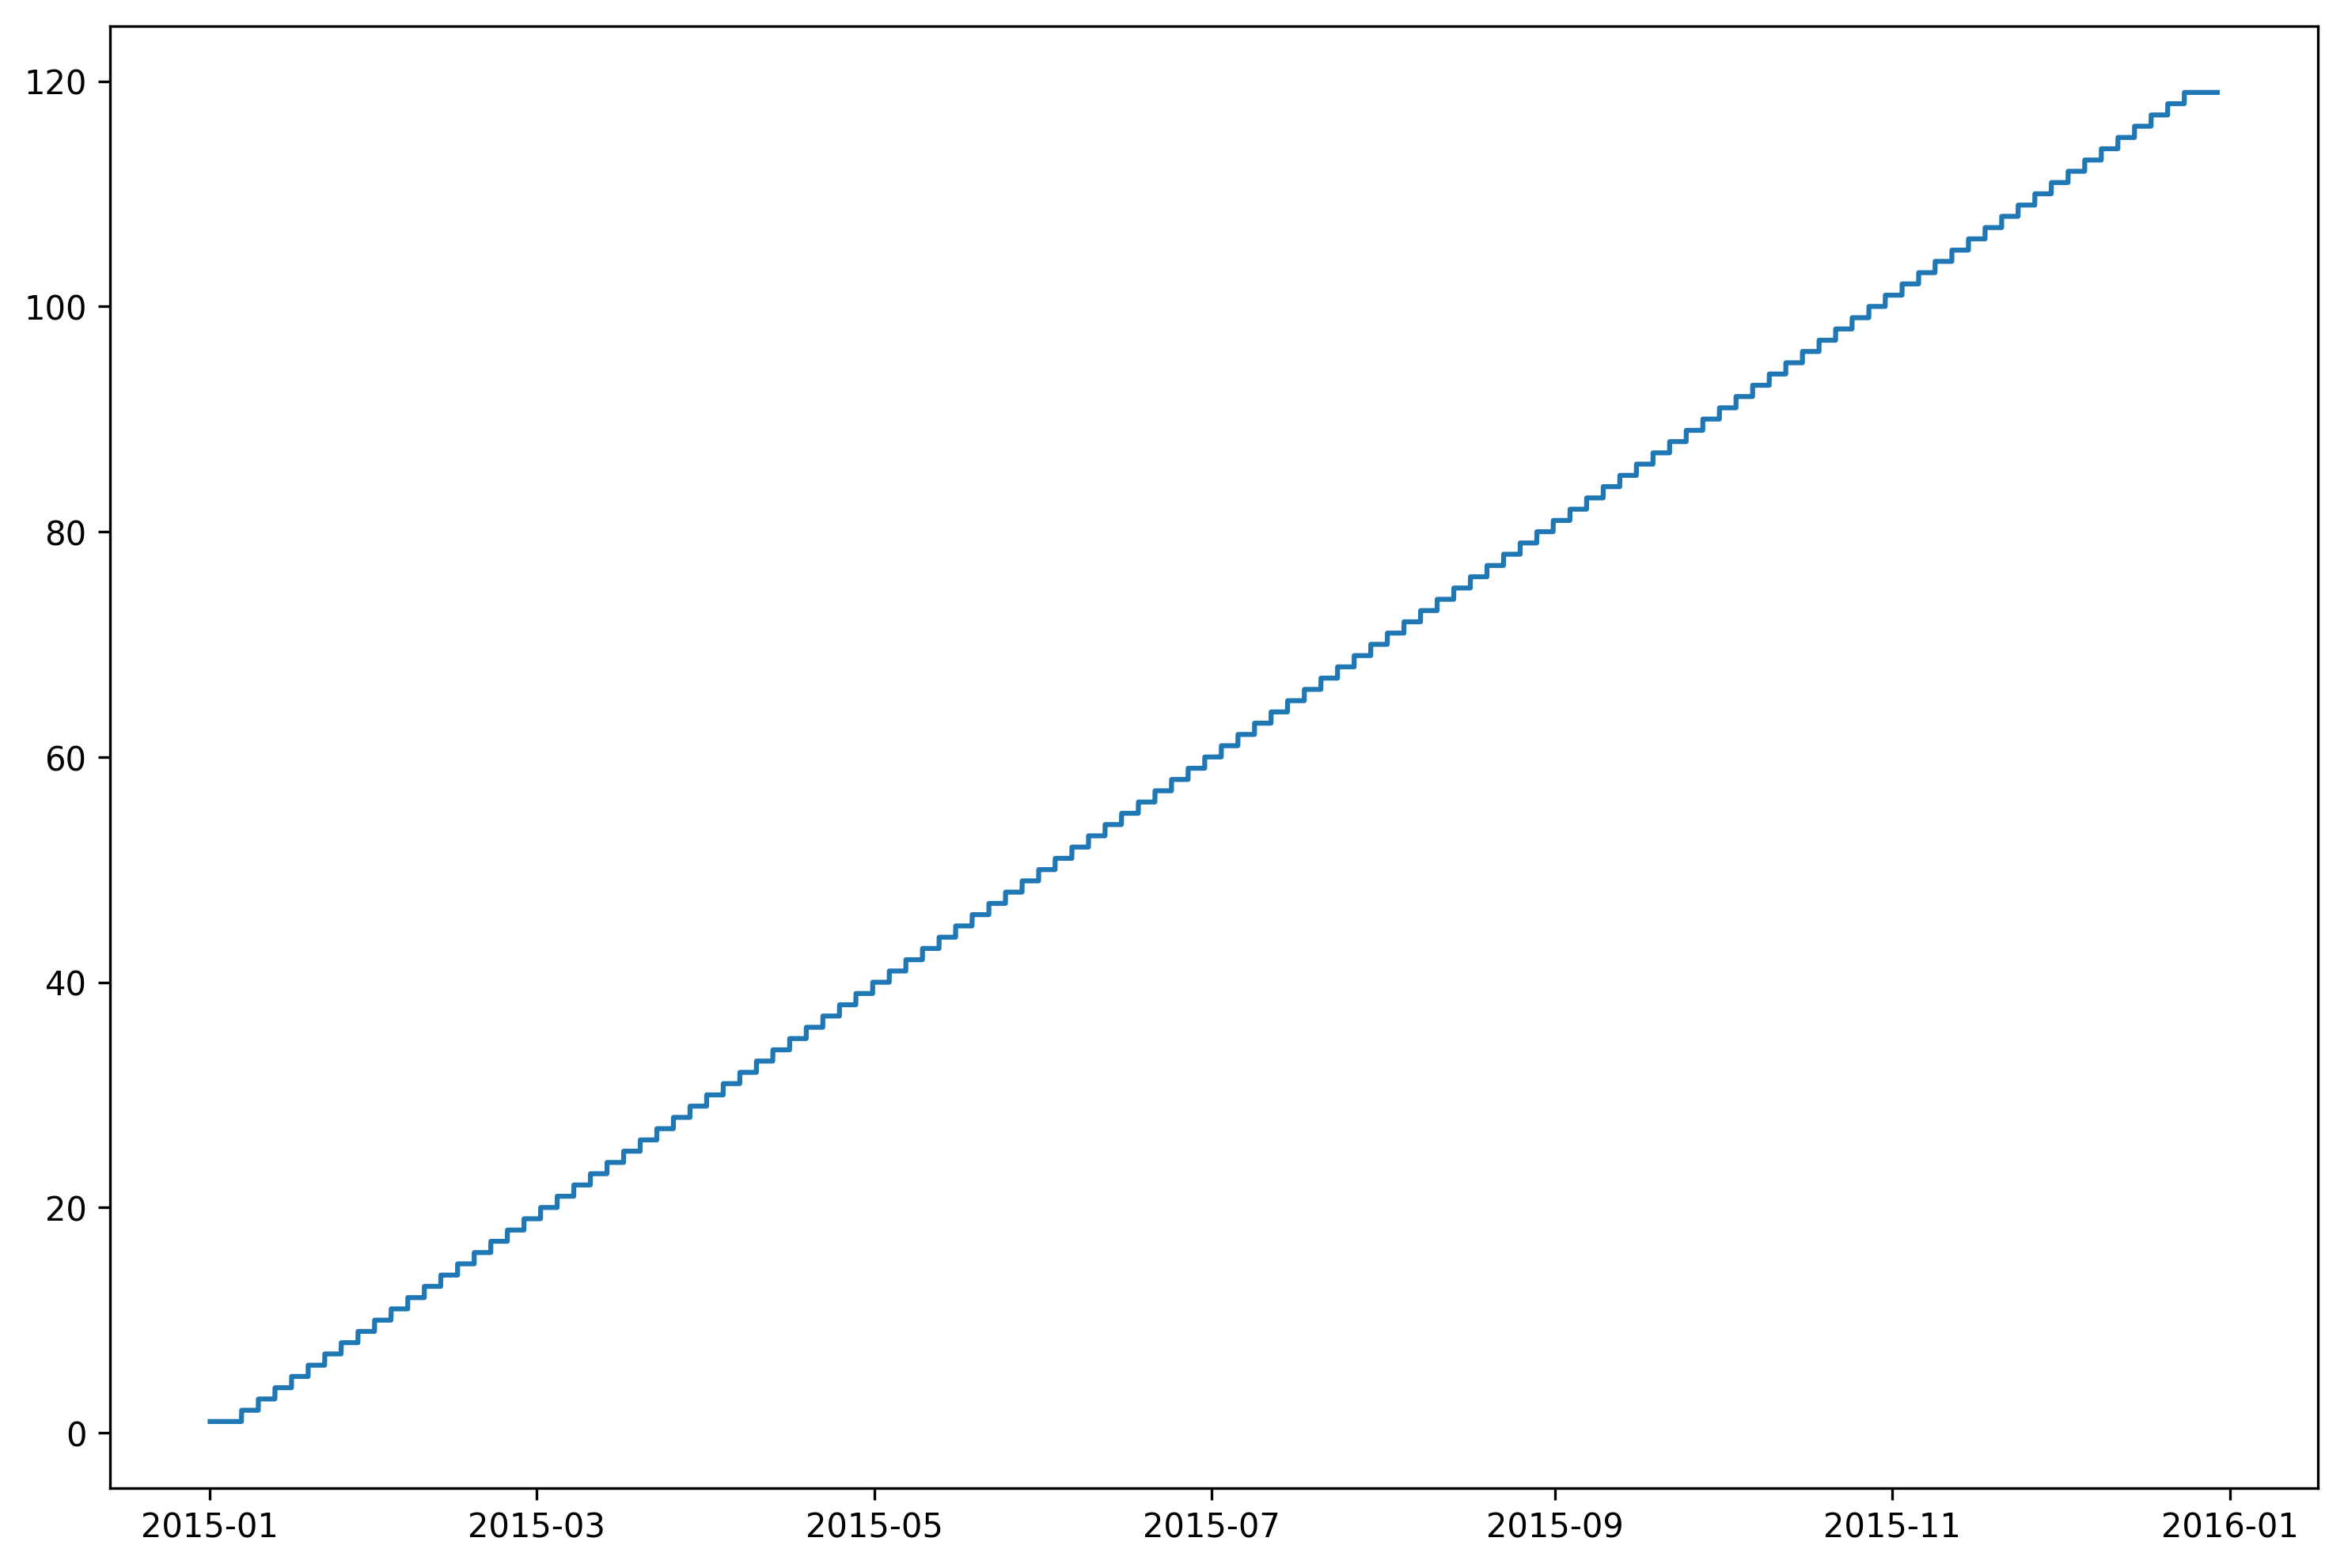

  1.881859 seconds (6.42 M allocations: 269.098 MiB, 16.90% gc time)


In [288]:
buffer_df_per_window = DataFrame[]
@time for window_num in 1:150
    try
        ts = Batch.read_ts(Batch.get_window(window_num), "simpler", test_usaf)
    catch
        break
    end
    mid = StatsBase.midpoints(ts)
    buffer = get_midpoints_buffer(ts)
    df = DataFrame(
            :ts_midpoint => mid, 
            :imid => 1:length(mid), 
            :buffer => buffer, 
            :window => window_num,
            )
    push!(buffer_df_per_window, df)
end
buffer_df = vcat(buffer_df_per_window...)
best_df = DataFrames.by(
        buffer_df,
        :ts_midpoint, 
        df -> df[indmax(df[:buffer]), [:imid, :window]];
        sort=true,
        )
plt.plot(best_df[:ts_midpoint], best_df[:window])
;

In [304]:
function Base.size(arr::AxisArray, axis_sym::Symbol)
    iaxis = axisdim(arr, Axis{axis_sym})
    return size(arr, iaxis)
end

In [290]:
size(temp_impute)

(1000, 352, 4)

# Iterating over fitting windows

In [312]:
function extract_mean(chains::AxisArray, ts::AbstractVector{DateTime}, window_num::Int, best_df::DataFrame)
    # extract imputed temperatures
    temp_impute = Batch.get_temperatures_reparam(chains)
    is_best = best_df[:window] .== window_num
    imid_is_best = best_df[is_best, :imid]
    best_istart, best_iend = extrema(imid_is_best)
    ts_best = ts[best_istart:best_iend+1]
    println("obtaining mean between ", ts[best_istart], " and ", ts[best_iend+1])
    nchains = size(temp_impute, :chain)
    nsamples = size(temp_impute, :sample)
    mean_by_sample = Vector{Float64}(nchains*nsamples)
    isample_x_chain = 0
    for ichain in 1:nchains
        for isample in 1:nsamples
            isample_x_chain += 1

            temp = view(temp_impute, 
                Axis{:sample}(isample), 
                Axis{:param}(:), 
                Axis{:chain}(ichain))
            temp_best = view(temp, best_istart:best_iend+1)
            @assert length(temp_best) == length(ts_best)
            mean_best = mean_temp(temp_best, ts_best)

            mean_by_sample[isample_x_chain] = mean_best
        end
    end
    duration = ts[best_iend+1]-ts[best_istart]
    return mean_by_sample, duration
end

extract_mean (generic function with 3 methods)

In [311]:
stan_fw = Batch.get_window(10)
chains, ts = Batch.get_chains_and_ts(stan_fw, "simpler", test_usaf)
extract_mean(chains, ts, 10, best_df)
stan_fw = Batch.get_window(11)
chains, ts = Batch.get_chains_and_ts(stan_fw, "simpler", test_usaf)
extract_mean(chains, ts, 11, best_df)
;

obtaining mean between 2015-01-30T17:54:00 and 2015-02-02T16:54:00
obtaining mean between 2015-02-02T16:54:00 and 2015-02-05T17:54:00


In [389]:
Batch.get_window(42)

Batch.FittingWindow(2015-05-04, 2015-05-13)

In [315]:
models = ("simpler", )
@time begin
    GPmodel = "simpler"
    println("")
    println("==========")
    println(GPmodel)
    println("==========")
    window_means = Float64[]
    window_vars = Float64[]
    window_durations = Dates.Millisecond[]

    for window_num in 1:150
        println(window_num)
        # fitting window for Stan
        stan_fw = Batch.get_window(window_num)

        local chains
        local ts
        try
            # obtain Stan output samples
            chains, ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
        catch
            break
        end
        temp_mean, duration = extract_mean(chains, ts, window_num, best_df)
        println(window_num, ": ", mean(temp_mean))
        push!(window_means, mean(temp_mean))
        push!(window_vars, var(temp_mean))
        push!(window_durations, duration)
    end
end


simpler
1
obtaining mean between 2015-01-01T00:00:00 and 2015-01-06T16:54:00
1: -10.411677897304562
2
obtaining mean between 2015-01-06T16:54:00 and 2015-01-09T17:54:00
2: -17.127016064437214
3
obtaining mean between 2015-01-09T17:54:00 and 2015-01-12T17:54:00
3: -12.7371838796331
4
obtaining mean between 2015-01-12T17:54:00 and 2015-01-15T17:54:00
4: -12.426680672160607
5
obtaining mean between 2015-01-15T17:54:00 and 2015-01-18T17:54:00
5: 0.193648168388877
6
obtaining mean between 2015-01-18T17:54:00 and 2015-01-21T17:24:00
6: 0.5806464595219076
7
obtaining mean between 2015-01-21T17:24:00 and 2015-01-24T16:54:00
7: -1.817656302501669
8
obtaining mean between 2015-01-24T16:54:00 and 2015-01-27T17:54:00
8: 0.8699545113395147
9
obtaining mean between 2015-01-27T17:54:00 and 2015-01-30T17:54:00
9: -2.0361698838078826
10
obtaining mean between 2015-01-30T17:54:00 and 2015-02-02T16:54:00
10: -6.605246114115217
11
obtaining mean between 2015-02-02T16:54:00 and 2015-02-05T17:54:00
11: -14

obtaining mean between 2015-09-24T17:54:00 and 2015-09-27T17:54:00
89: 19.497477898125
90
obtaining mean between 2015-09-27T17:54:00 and 2015-09-30T17:54:00
90: 17.202913693620946
91
obtaining mean between 2015-09-30T17:54:00 and 2015-10-03T17:54:00
91: 10.074687962519098
92
obtaining mean between 2015-10-03T17:54:00 and 2015-10-06T17:54:00
92: 11.176214566227431
93
obtaining mean between 2015-10-06T17:54:00 and 2015-10-09T17:54:00
93: 15.486905144943288
94
obtaining mean between 2015-10-09T17:54:00 and 2015-10-12T17:54:00
94: 15.22783168621817
95
obtaining mean between 2015-10-12T17:54:00 and 2015-10-15T17:54:00
95: 11.421643170684026
96
obtaining mean between 2015-10-15T17:54:00 and 2015-10-18T17:54:00
96: 5.252708143370601
97
obtaining mean between 2015-10-18T17:54:00 and 2015-10-21T17:23:00
97: 15.751165600457567
98
obtaining mean between 2015-10-21T17:23:00 and 2015-10-24T16:54:00
98: 12.200936985635636
99
obtaining mean between 2015-10-24T16:54:00 and 2015-10-27T17:50:00
99: 8.40

# Averaging over windows

**truth**

In [341]:
@printf("%.3f °C", true_mean_temp)

9.497 °C

**dumb estimate**

In [347]:
@printf("%.3f °C from TnTx obtained at %d:00", meanTnTx_by_hr[18], hours[18]/Hour(1))

9.716 °C from TnTx obtained at 17:00

**estimate using imputations**

In [348]:
weights = window_durations ./ Dates.Millisecond(1)
est_mean_temp = mean(window_means, StatsBase.Weights(window_durations ./ Dates.Millisecond(1)))
variance_of_sum = sum(window_vars .* (weights.^2))
sum_weights = sum(weights)
variance_of_mean = variance_of_sum / sum_weights^2
@printf("%.3f  °C ± %.3f", est_mean_temp, √variance_of_mean)

9.474  °C ± 0.020